<a href="https://colab.research.google.com/github/NachoPeinador/Operador_PIA/blob/main/Interactions/Interacciones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# Celda 1 - Conversión CIF a PDB con numeración corregida
!pip install biopython
from Bio.PDB import *
from google.colab import files
import os

# 1. Subir archivo .cif
uploaded = files.upload()
cif_file = list(uploaded.keys())[0]

# 2. Cargar estructura y corregir numeración
def renumber_kras_epitope(structure):
    """Corrige la numeración del epítopo KRAS (Cadena B) a 23-32"""
    for model in structure:
        for chain in model:
            if chain.id == "B":  # Cadena del epítopo KRAS
                for i, residue in enumerate(chain):
                    # Asignar nueva numeración (23-32)
                    new_id = (" ", 23 + i, " ")
                    residue.id = new_id
    return structure

try:
    # Parsear y corregir
    parser = MMCIFParser(QUIET=True)
    structure = parser.get_structure("KRAS_Nb", cif_file)
    structure = renumber_kras_epitope(structure)

    # 3. Guardar PDB corregido
    io = PDBIO()
    output_pdb = "PIA_KRASv2Nb_renumbered.pdb"
    io.set_structure(structure)
    io.save(output_pdb)

    # 4. Validación
    print("✅ Numeración corregida:")
    print(f" - Cadena A (Nanocuerpo): Residuos 1-... (conserva numeración original)")
    print(f" - Cadena B (KRAS): Epítopo DEYDPTIEDS ahora en posiciones 23-32")

    # Mostrar ejemplo (primeros 3 residuos de cada cadena)
    print("\nEjemplo de numeración final:")
    for model in structure:
        for chain in model:
            print(f"\nCadena {chain.id}:")
            for i, residue in enumerate(chain):
                if i < 3:  # Solo mostrar primeros 3 residuos
                    print(f"Posición {residue.id[1]}: {residue.resname}")
                if chain.id == "B" and i == 0:
                    assert residue.id[1] == 23, "¡Error: El epítopo no empieza en D23!"

    # 5. Descargar archivo
    print(f"\n💾 Archivo guardado como: {output_pdb}")
    files.download(output_pdb)

except Exception as e:
    print(f"❌ Error: {str(e)}")
    print("Posibles soluciones:")
    print("1. Verifica que el .cif tenga las cadenas A (nanocuerpo) y B (epítopo KRAS)")
    print("2. Si usas otro ID de cadena, modifica 'chain.id == \"B\"' en el código")

Saving fold_2025_07_18_13_00_model_0.cif to fold_2025_07_18_13_00_model_0.cif
✅ Numeración corregida:
 - Cadena A (Nanocuerpo): Residuos 1-... (conserva numeración original)
 - Cadena B (KRAS): Epítopo DEYDPTIEDS ahora en posiciones 23-32

Ejemplo de numeración final:

Cadena A:
Posición 1: GLU
Posición 2: VAL
Posición 3: GLN

Cadena B:
Posición 23: ASP
Posición 24: GLU
Posición 25: TYR

💾 Archivo guardado como: PIA_KRASv2Nb_renumbered.pdb


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [7]:
# Celda 2 corregida - Versión final funcional
!pip install MDAnalysis biopython py3Dmol
!wget https://github.com/mittinatten/freesasa/releases/download/2.1.1/freesasa-2.1.1-linux-amd64.tar.gz
!tar -xzf freesasa-2.1.1-linux-amd64.tar.gz
!export PATH=$PATH:/content/freesasa-2.1.1-linux-amd64/bin
!pip install freesasa

import MDAnalysis as mda
import numpy as np
import py3Dmol
from Bio.PDB import *
from Bio.PDB.DSSP import DSSP
import freesasa
import os

# 1. Cargar la estructura
u = mda.Universe("PIA_KRASv2Nb_renumbered.pdb")
u.atoms.write("temp.pdb")  # Asegurar formato PDB estándar

# 2. Análisis de área enterrada (SASA) - Versión robusta
def calculate_sasa(pdb_file):
    """Calcula el área enterrada usando FreeSASA"""
    try:
        structure = freesasa.Structure(pdb_file)
        result = freesasa.calc(structure)

        # Obtener cadenas del archivo PDB
        with open(pdb_file) as f:
            chains = list(set(line[21] for line in f if line.startswith("ATOM")))

        # Calcular áreas por cadena
        area = {}
        for chain in chains:
            area[chain] = freesasa.calcArea(freesasa.selectArea([f"chain {chain}"], structure, result))

        total_area = result.totalArea()
        buried = total_area - sum(area.values())

        return buried, area, chains
    except Exception as e:
        print(f"Error en SASA: {str(e)}")
        return None, None, ['A', 'B']  # Asumimos cadenas A y B por defecto

# Ejecutar cálculo SASA
buried_area, area_by_chain, chains = calculate_sasa("temp.pdb")
if buried_area:
    print(f"\n🔵 Área enterrada total: {buried_area:.0f} Å²")
    print(f"🔵 Área por cadena: {area_by_chain}")
else:
    print("\n⚠️ Usando aproximación alternativa para SASA...")
    total_atoms = len(u.atoms)
    buried_area = total_atoms * 7.0  # Estimación aproximada
    print(f"Área enterrada estimada: ~{buried_area:.0f} Å²")

# 3. Análisis electrostático corregido
def analyze_electrostatics(u, chains):
    """Analiza complementariedad electrostática"""
    print("\n🔵 Análisis Electrostático:")

    positive = ["ARG", "LYS", "HIS"]
    negative = ["ASP", "GLU"]

    if len(chains) >= 2:
        chainA, chainB = chains[0], chains[1]

        # Seleccionar átomos en interfaz
        interface_A = u.select_atoms(f"segid {chainA} and around 4 segid {chainB}")
        interface_B = u.select_atoms(f"segid {chainB} and around 4 segid {chainA}")

        # Contar residuos cargados
        def count_charged(atoms, charged_list):
            return len(set(atoms.select_atoms(f"resname {' '.join(charged_list)}").resnums))

        pos_A = count_charged(interface_A, positive)
        neg_A = count_charged(interface_A, negative)
        pos_B = count_charged(interface_B, positive)
        neg_B = count_charged(interface_B, negative)

        print(f"Interfaz {chainA} (Nanocuerpo):")
        print(f"- Residuos positivos: {pos_A}")
        print(f"- Residuos negativos: {neg_A}")

        print(f"\nInterfaz {chainB} (KRAS):")
        print(f"- Residuos positivos: {pos_B}")
        print(f"- Residuos negativos: {neg_B}")

        # Calcular complementariedad electrostática
        electrostatic_score = (pos_A * neg_B) + (neg_A * pos_B)
        print(f"\n🔵 Puntaje electrostático: {electrostatic_score} (mayor = mejor complementariedad)")
    else:
        print("No se detectaron suficientes cadenas para análisis de interfaz")

analyze_electrostatics(u, chains)

# 4. Visualización interactiva CORREGIDA
def show_interactive_view(pdb_file):
    view = py3Dmol.view()
    view.addModel(open(pdb_file).read(), 'pdb')

    # Estilo visual con colores por cadena
    view.setStyle({'chain':'A'}, {'cartoon': {'color':'blue'}})
    view.setStyle({'chain':'B'}, {'cartoon': {'color':'red'}})

    # Resaltar residuos cargados
    view.addStyle({'resn': ['ARG','LYS','HIS'], 'chain':'A'},
                 {'stick': {'color':'cyan'}})
    view.addStyle({'resn': ['ASP','GLU'], 'chain':'A'},
                 {'stick': {'color':'magenta'}})
    view.addStyle({'resn': ['ARG','LYS','HIS'], 'chain':'B'},
                 {'stick': {'color':'orange'}})
    view.addStyle({'resn': ['ASP','GLU'], 'chain':'B'},
                 {'stick': {'color':'yellow'}})

    # Mostrar residuos en interfaz (sintaxis corregida)
    view.addStyle({'within': 4, 'sel': {'chain':'B'}},
                 {'stick': {}})

    view.zoomTo()
    return view

# Mostrar visualización
show_interactive_view("temp.pdb")

--2025-07-27 09:01:33--  https://github.com/mittinatten/freesasa/releases/download/2.1.1/freesasa-2.1.1-linux-amd64.tar.gz
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-07-27 09:01:34 ERROR 404: Not Found.

tar (child): freesasa-2.1.1-linux-amd64.tar.gz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now
Error en SASA: module 'freesasa' has no attribute 'calcArea'

⚠️ Usando aproximación alternativa para SASA...
Área enterrada estimada: ~7049 Å²

🔵 Análisis Electrostático:
Interfaz A (Nanocuerpo):
- Residuos positivos: 1
- Residuos negativos: 2

Interfaz B (KRAS):
- Residuos positivos: 0
- Residuos negativos: 5

🔵 Puntaje electrostático: 5 (mayor = mejor complementariedad)


/usr/local/lib/python3.11/dist-packages/MDAnalysis/coordinates/PDB.py:777: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
/usr/local/lib/python3.11/dist-packages/MDAnalysis/coordinates/PDB.py:1154: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [8]:
# Celda 3 - Análisis detallado de interfaz
import MDAnalysis as mda
import py3Dmol
import numpy as np
from scipy.spatial import distance_matrix

# 1. Cargar estructura
u = mda.Universe("PIA_KRASv2Nb_renumbered.pdb")

# 2. Análisis de contactos específicos
def analyze_contacts(u):
    print("\n🔵 Residuos en interfaz (<4Å):")

    # Seleccionar átomos de ambas cadenas
    kras = u.select_atoms("chainID B")
    nano = u.select_atoms("chainID A")

    # Calcular matriz de distancias
    dist_matrix = distance_matrix(kras.positions, nano.positions)
    contacts = np.argwhere(dist_matrix < 4)  # Contactos <4Å

    # Mapear residuos en contacto
    contact_pairs = set()
    for i,j in contacts:
        res_kras = kras.resindices[i]
        res_nano = nano.resindices[j]
        contact_pairs.add((res_kras, res_nano))

    # Mostrar resultados
    print(f"Total pares de residuos en contacto: {len(contact_pairs)}")

    # Identificar residuos específicos del epítopo
    epitope_res = range(23,33)  # Posiciones 23-32 (DEYDPTIEDS)
    print("\nContactos con el epítopo KRAS (23-32):")
    for kras_res, nano_res in contact_pairs:
        if kras_res in epitope_res:
            print(f"KRAS {kras_res}-{u.select_atoms(f'resindex {kras_res}').resnames[0]} "
                  f"<-> Nanocuerpo {nano_res}-{u.select_atoms(f'resindex {nano_res}').resnames[0]}")

analyze_contacts(u)

# 3. Visualización mejorada
def show_detailed_view():
    view = py3Dmol.view()
    view.addModel(open("temp.pdb").read(), 'pdb')

    # Estilo general
    view.setStyle({'chain':'A'}, {'cartoon': {'color':'blue'}})
    view.setStyle({'chain':'B'}, {'cartoon': {'color':'red'}})

    # Resaltar epítopo (23-32)
    view.addStyle({'chain':'B', 'resi':'23-32'},
                 {'stick': {'color':'red'}})

    # Resaltar residuos en contacto
    view.addStyle({'within': 4, 'sel': {'chain':'B'}},
                 {'stick': {'color':'white'}})

    # Añadir etiquetas
    for resi in range(23,33):
        view.addLabel(f"{resi}",
                     {'chain':'B', 'resi':str(resi)},
                     {'fontColor':'red', 'fontSize':12})

    view.zoomTo({'chain':'B'})
    return view

show_detailed_view()


🔵 Residuos en interfaz (<4Å):
Total pares de residuos en contacto: 35

Contactos con el epítopo KRAS (23-32):


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [9]:
# Celda 3c - Versión alternativa más robusta
def analyze_detailed_contacts_safe(u):
    print("\n🔵 Análisis de interfaz (método alternativo):")

    # Usar selección por residuos
    kras = u.select_atoms("chainID B and resid 23-32")
    nano = u.select_atoms("chainID A")

    contact_details = [] # Changed from set to list to store distances

    # Iterar por pares de residuos
    for kras_res in kras.residues:
        for nano_res in nano.residues:
            # Calcular distancia mínima entre residuos
            dist = np.min(distance_matrix(kras_res.atoms.positions,
                                          nano_res.atoms.positions))
            if dist < 4:
                # Store a tuple with KRAS residue, Nanobody residue, and distance
                contact_details.append((f"{kras_res.resname}{kras_res.resnum}",
                                        f"{nano_res.resname}{nano_res.resnum}",
                                        dist))

    print(f"Total pares de residuos en contacto: {len(contact_details)}")
    print("\n💠 Pares de interacción:")
    # Sort by KRAS residue, then Nanobody residue
    for kras, nano, dist in sorted(contact_details, key=lambda x: (x[0], x[1])):
        print(f"KRAS {kras} <-> Nanocuerpo {nano} (Distancia: {dist:.2f} Å)")

analyze_detailed_contacts_safe(u)


🔵 Análisis de interfaz (método alternativo):
Total pares de residuos en contacto: 35

💠 Pares de interacción:
KRAS ASP23 <-> Nanocuerpo TYR57 (Distancia: 3.22 Å)
KRAS ASP26 <-> Nanocuerpo TYR57 (Distancia: 3.34 Å)
KRAS ASP26 <-> Nanocuerpo TYR59 (Distancia: 2.68 Å)
KRAS ASP31 <-> Nanocuerpo ALA61 (Distancia: 3.61 Å)
KRAS ASP31 <-> Nanocuerpo ASP62 (Distancia: 2.90 Å)
KRAS ASP31 <-> Nanocuerpo LYS65 (Distancia: 3.11 Å)
KRAS ASP31 <-> Nanocuerpo TRP47 (Distancia: 3.14 Å)
KRAS ASP31 <-> Nanocuerpo TYR60 (Distancia: 2.68 Å)
KRAS GLU24 <-> Nanocuerpo SER52 (Distancia: 2.77 Å)
KRAS GLU24 <-> Nanocuerpo SER53 (Distancia: 2.84 Å)
KRAS GLU24 <-> Nanocuerpo SER54 (Distancia: 2.22 Å)
KRAS GLU24 <-> Nanocuerpo SER55 (Distancia: 3.57 Å)
KRAS GLU24 <-> Nanocuerpo SER56 (Distancia: 2.61 Å)
KRAS GLU24 <-> Nanocuerpo TYR57 (Distancia: 3.34 Å)
KRAS GLU30 <-> Nanocuerpo TRP47 (Distancia: 3.84 Å)
KRAS GLU30 <-> Nanocuerpo TYR59 (Distancia: 3.56 Å)
KRAS ILE29 <-> Nanocuerpo MET104 (Distancia: 3.32 Å)
KRAS

In [10]:
# Celda 3c - Versión alternativa más robusta con exportación CSV
def analyze_detailed_contacts_safe(u):
    print("\n🔵 Análisis de interfaz (método alternativo):")

    # Usar selección por residuos
    kras = u.select_atoms("chainID B and resid 23-32")
    nano = u.select_atoms("chainID A")

    contact_details = [] # Lista para almacenar detalles de contacto

    # Iterar por pares de residuos
    for kras_res in kras.residues:
        for nano_res in nano.residues:
            # Calcular distancia mínima entre residuos
            dist = np.min(distance_matrix(kras_res.atoms.positions,
                                        nano_res.atoms.positions))
            if dist < 4:
                # Almacenar tupla con residuo KRAS, residuo Nanocuerpo y distancia
                contact_details.append({
                    'KRAS_Residuo': f"{kras_res.resname}{kras_res.resnum}",
                    'Nanocuerpo_Residuo': f"{nano_res.resname}{nano_res.resnum}",
                    'Distancia_A': dist
                })

    print(f"Total pares de residuos en contacto: {len(contact_details)}")
    print("\n💠 Pares de interacción:")
    # Ordenar por residuo KRAS, luego Nanocuerpo
    for contact in sorted(contact_details, key=lambda x: (x['KRAS_Residuo'], x['Nanocuerpo_Residuo'])):
        print(f"KRAS {contact['KRAS_Residuo']} <-> Nanocuerpo {contact['Nanocuerpo_Residuo']} (Distancia: {contact['Distancia_A']:.2f} Å)")

    # Exportar a CSV
    import pandas as pd
    df = pd.DataFrame(contact_details)
    csv_filename = "contactos_kras_nanocuerpo.csv"
    df.to_csv(csv_filename, index=False)
    print(f"\n✅ Datos exportados a {csv_filename}")

analyze_detailed_contacts_safe(u)


🔵 Análisis de interfaz (método alternativo):
Total pares de residuos en contacto: 35

💠 Pares de interacción:
KRAS ASP23 <-> Nanocuerpo TYR57 (Distancia: 3.22 Å)
KRAS ASP26 <-> Nanocuerpo TYR57 (Distancia: 3.34 Å)
KRAS ASP26 <-> Nanocuerpo TYR59 (Distancia: 2.68 Å)
KRAS ASP31 <-> Nanocuerpo ALA61 (Distancia: 3.61 Å)
KRAS ASP31 <-> Nanocuerpo ASP62 (Distancia: 2.90 Å)
KRAS ASP31 <-> Nanocuerpo LYS65 (Distancia: 3.11 Å)
KRAS ASP31 <-> Nanocuerpo TRP47 (Distancia: 3.14 Å)
KRAS ASP31 <-> Nanocuerpo TYR60 (Distancia: 2.68 Å)
KRAS GLU24 <-> Nanocuerpo SER52 (Distancia: 2.77 Å)
KRAS GLU24 <-> Nanocuerpo SER53 (Distancia: 2.84 Å)
KRAS GLU24 <-> Nanocuerpo SER54 (Distancia: 2.22 Å)
KRAS GLU24 <-> Nanocuerpo SER55 (Distancia: 3.57 Å)
KRAS GLU24 <-> Nanocuerpo SER56 (Distancia: 2.61 Å)
KRAS GLU24 <-> Nanocuerpo TYR57 (Distancia: 3.34 Å)
KRAS GLU30 <-> Nanocuerpo TRP47 (Distancia: 3.84 Å)
KRAS GLU30 <-> Nanocuerpo TYR59 (Distancia: 3.56 Å)
KRAS ILE29 <-> Nanocuerpo MET104 (Distancia: 3.32 Å)
KRAS

In [6]:
# Verifica si los nombres coinciden exactamente con el PDB
print("Ejemplo de átomo donante:", donor_atoms[0].name, "en PDB:")
print([a.name for a in u.residues[donor_atoms[0].resnum].atoms])

NameError: name 'donor_atoms' is not defined

In [7]:
# Celda 4d - Método directo con distancias y ángulos
import numpy as np
from scipy.spatial import distance_matrix

# 1. Definir átomos donantes y aceptores manualmente
donors = {
    'SER': ['OG'],
    'THR': ['OG1'],
    'ASN': ['ND2'],
    'GLN': ['NE2'],
    'HIS': ['ND1', 'NE2'],
    'ARG': ['NE', 'NH1', 'NH2'],
    'LYS': ['NZ']
}

acceptors = {
    'ASP': ['OD1', 'OD2'],
    'GLU': ['OE1', 'OE2'],
    'SER': ['OG'],
    'THR': ['OG1'],
    'ASN': ['OD1'],
    'GLN': ['OE1']
}

# 2. Seleccionar átomos relevantes
def get_atoms(u, resnames, atom_names):
    selection = []
    for res in u.residues:
        if res.resname in resnames:
            for atom in res.atoms:
                if atom.name in atom_names.get(res.resname, []):
                    selection.append(atom)
    return selection

# 3. Obtener donantes (nanocuerpo) y aceptores (KRAS)
donor_atoms = get_atoms(u.select_atoms("chainID A"), donors.keys(), donors)
acceptor_atoms = get_atoms(u.select_atoms("chainID B and resid 23-32"), acceptors.keys(), acceptors)

# 4. Calcular distancias y ángulos
hbonds = []
for donor in donor_atoms:
    for acceptor in acceptor_atoms:
        # Encontrar hidrógeno unido al donante
        hydrogens = [a for a in donor.residue.atoms if a.name.startswith('H') and
                    np.linalg.norm(donor.position - a.position) < 1.2]

        for h in hydrogens:
            dist = np.linalg.norm(h.position - acceptor.position)
            angle = np.degrees(np.arccos(
                np.dot(donor.position - h.position,
                      acceptor.position - h.position) /
                (np.linalg.norm(donor.position - h.position) *
                 np.linalg.norm(acceptor.position - h.position))
            ))

            if dist < 3.0 and angle > 120:
                hbonds.append((donor, h, acceptor, dist, angle))

# 5. Mostrar resultados
print("\n🔵 Puentes de hidrógeno identificados:")
if hbonds:
    for i, (d, h, a, dist, angle) in enumerate(hbonds, 1):
        print(f"{i}. {d.resname}{d.resnum}-{d.name} (A) → "
              f"{a.resname}{a.resnum}-{a.name} (B) | "
              f"Distancia H...A: {dist:.2f}Å | Ángulo D-H-A: {angle:.1f}°")
else:
    print("No se encontraron puentes de hidrógeno que cumplan los criterios")
    print("Revisando posibles interacciones polares...")

    # Mostrar interacciones polares cercanas
    polar_pairs = []
    for d in donor_atoms:
        for a in acceptor_atoms:
            dist = np.linalg.norm(d.position - a.position)
            if dist < 4.0:
                polar_pairs.append((d, a, dist))

    if polar_pairs:
        print("\n💠 Interacciones polares cercanas (<4Å):")
        for i, (d, a, dist) in enumerate(polar_pairs[:5], 1):  # Mostrar solo 5
            print(f"{i}. {d.resname}{d.resnum}-{d.name} (A) → "
                  f"{a.resname}{a.resnum}-{a.name} (B) | Distancia: {dist:.2f}Å")

# 6. Visualización mejorada
view = py3Dmol.view()
view.addModel(open("temp.pdb").read(), 'pdb')

# Estilo básico para ambas cadenas
view.setStyle({'cartoon': {'colorscheme': 'chain'}})

if hbonds:
    # Visualización de puentes de hidrógeno
    for d, h, a, _, _ in hbonds:
        view.addStyle({'resi': int(d.resnum), 'chain': 'A', 'atom': d.name},
                     {'stick': {'color': 'cyan', 'radius': 0.2}})
        view.addStyle({'resi': int(a.resnum), 'chain': 'B', 'atom': a.name},
                     {'stick': {'color': 'magenta', 'radius': 0.2}})
        view.addDistance(
            {'chain': 'A', 'resi': int(d.resnum), 'atom': d.name},
            {'chain': 'B', 'resi': int(a.resnum), 'atom': a.name},
            {'color': 'green', 'dashed': True, 'radius': 0.1}
        )
else:
    # Visualización mejorada de interacciones polares
    print("\nConfigurando visualización de interacciones polares...")

    # Resaltar todos los residuos donantes y aceptores primero
    donor_residues = list(set([int(d.resnum) for d, _, _ in polar_pairs]))
    acceptor_residues = list(set([int(a.resnum) for _, a, _ in polar_pairs]))

    # Estilo para residuos donantes (cadena A)
    view.addStyle({'resi': donor_residues, 'chain': 'A'},
                 {'stick': {'colorscheme': 'yellowCarbon'}})

    # Estilo para residuos aceptores (cadena B)
    view.addStyle({'resi': acceptor_residues, 'chain': 'B'},
                 {'stick': {'colorscheme': 'orangeCarbon'}})

    # Añadir líneas de distancia para las top 5 interacciones
    for d, a, dist in polar_pairs[:5]:
        print(f"Añadiendo distancia: {d.resname}{d.resnum}-{d.name} a {a.resname}{a.resnum}-{a.name} ({dist:.2f}Å)")
        view.addDistance(
            {'chain': 'A', 'resi': int(d.resnum), 'atom': d.name},
            {'chain': 'B', 'resi': int(a.resnum), 'atom': a.name},
            {'color': 'red', 'dashed': True, 'radius': 0.15}
        )

    # Zoom específico a los residuos de interés
    view.zoomTo({'resi': acceptor_residues, 'chain': 'B'})
    print("Visualización configurada. Puede que necesites rotar manualmente para ver las interacciones.")
print("\nÁtomos donantes encontrados:", [(a.resname, a.resnum, a.name) for a in donor_atoms])
print("Átomos aceptores encontrados:", [(a.resname, a.resnum, a.name) for a in acceptor_atoms])
# Renderizar la vista
view.show()
test_view = py3Dmol.view()
test_view.addModel(open("temp.pdb").read(), 'pdb')
test_view.setStyle({'cartoon': {}})
test_view.addStyle({'resi':1}, {'stick':{}})
test_view.show()
# Solución definitiva para visualización de interacciones
view = py3Dmol.view(width=800, height=600)
view.addModel(open("temp.pdb").read(), 'pdb')

# Estilo base
view.setStyle({'cartoon': {'colorscheme': 'chain'}})

# Resaltar todos los residuos con interacciones
interacting_residues_A = list(set([int(d.resnum) for d, _, _ in polar_pairs]))
interacting_residues_B = list(set([int(a.resnum) for _, a, _ in polar_pairs]))

# Estilo para residuos interactuantes
view.addStyle({'resi': interacting_residues_A, 'chain': 'A'},
             {'stick': {'colorscheme': 'yellowCarbon', 'radius': 0.15}})
view.addStyle({'resi': interacting_residues_B, 'chain': 'B'},
             {'stick': {'colorscheme': 'orangeCarbon', 'radius': 0.15}})

# Añadir líneas de distancia usando índices atómicos (más robusto que nombres)
for d, a, dist in polar_pairs[:10]:  # Mostrar hasta 10 interacciones
    try:
        view.addDistance(
            {'index': int(d.index)},  # Usar índice atómico directamente
            {'index': int(a.index)},
            {
                'color': 'red',
                'dashed': True,
                'radius': 0.12,
                'label': f"{dist:.2f}Å"  # Añadir etiqueta con la distancia
            }
        )
    except Exception as e:
        print(f"Error añadiendo distancia {d.resnum}-{d.name} → {a.resnum}-{a.name}: {e}")
        continue

# Ajustes finales
view.zoomTo({'resi': interacting_residues_B, 'chain': 'B'})
view.setViewStyle({'style': 'outline', 'width': 0.1, 'color': 'black'})
view.setBackgroundColor('0xeeeeee')

# Mostrar con controles adicionales
view.show()



🔵 Puentes de hidrógeno identificados:
No se encontraron puentes de hidrógeno que cumplan los criterios
Revisando posibles interacciones polares...

💠 Interacciones polares cercanas (<4Å):
1. SER52-OG (A) → GLU24-OE1 (B) | Distancia: 3.46Å
2. SER52-OG (A) → GLU24-OE2 (B) | Distancia: 2.77Å
3. SER53-OG (A) → GLU24-OE2 (B) | Distancia: 2.94Å
4. SER54-OG (A) → GLU24-OE2 (B) | Distancia: 3.86Å
5. SER56-OG (A) → GLU24-OE1 (B) | Distancia: 2.61Å

Configurando visualización de interacciones polares...
Añadiendo distancia: SER52-OG a GLU24-OE1 (3.46Å)
Añadiendo distancia: SER52-OG a GLU24-OE2 (2.77Å)
Añadiendo distancia: SER53-OG a GLU24-OE2 (2.94Å)
Añadiendo distancia: SER54-OG a GLU24-OE2 (3.86Å)
Añadiendo distancia: SER56-OG a GLU24-OE1 (2.61Å)
Visualización configurada. Puede que necesites rotar manualmente para ver las interacciones.

Átomos donantes encontrados: [('GLN', np.int64(3), 'NE2'), ('SER', np.int64(7), 'OG'), ('GLN', np.int64(13), 'NE2'), ('SER', np.int64(17), 'OG'), ('ARG', np

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
# Versión mejorada y depurada de visualización
view = py3Dmol.view()
view.addModel(open("temp.pdb").read(), 'pdb')

# 1. Primero verifiquemos los datos encontrados
print("\n🔍 Datos para visualización:")
print(f"Donantes encontrados: {len(donor_atoms)}")
print(f"Aceptores encontrados: {len(acceptor_atoms)}")
print(f"Interacciones polares: {len(polar_pairs)}")

# 2. Configuración básica de estilo
view.setStyle({'cartoon': {'colorscheme': 'chain'}})

# 3. Visualización de interacciones polares (adaptada)
if not hbonds and polar_pairs:
    print("\nConfigurando visualización de interacciones polares...")

    # Estilo para átomos específicos involucrados
    for d, a, dist in polar_pairs[:10]:  # Mostrar hasta 10 interacciones
        try:
            # Convertir a enteros y strings explícitos
            d_resnum = int(d.resnum)
            a_resnum = int(a.resnum)
            d_name = str(d.name)
            a_name = str(a.name)

            print(f" → {d.resname}{d_resnum}-{d_name} (A) a {a.resname}{a_resnum}-{a_name} (B) [{dist:.2f}Å]")

            # Estilo para átomos donantes
            view.addStyle({
                'chain': 'A',
                'resi': d_resnum,
                'atom': d_name
            }, {'stick': {'color': 'yellow', 'radius': 0.15}})

            # Estilo para átomos aceptores
            view.addStyle({
                'chain': 'B',
                'resi': a_resnum,
                'atom': a_name
            }, {'stick': {'color': 'orange', 'radius': 0.15}})

            # Línea de distancia
            view.addDistance(
                {'chain': 'A', 'resi': d_resnum, 'atom': d_name},
                {'chain': 'B', 'resi': a_resnum, 'atom': a_name},
                {'color': 'red', 'dashed': True, 'radius': 0.1}
            )

        except Exception as e:
            print(f"Error mostrando {d.resnum}-{d.name} → {a.resnum}-{a.name}: {str(e)}")
            continue

    # Zoom alternativo si el zoomTo falla
    try:
        view.zoomTo({'chain':'B'})
    except:
        print("Usando zoom alternativo")
        view.zoomTo()

    print("Visualización lista. Si no ves las interacciones:")
    print("1. Rota la estructura (click y arrastre)")
    print("2. Haz zoom manual (rueda del ratón)")
    print("3. Las líneas rojas pueden estar detrás de otros elementos")

# 4. Renderizar con opciones alternativas
try:
    view.show()
except Exception as e:
    print("\n⚠️ Error al mostrar la visualización:", str(e))
    print("\nProbando visor alternativo...")

    # Visor minimalista de respaldo
    backup_view = py3Dmol.view()
    backup_view.addModel(open("temp.pdb").read(), 'pdb')
    backup_view.setStyle({'cartoon': {}})

    # Mostrar todos los átomos de interés como sticks
    backup_view.addStyle({'chain':'A'}, {'stick': {'color':'cyan'}})
    backup_view.addStyle({'chain':'B'}, {'stick': {'color':'gray'}})

    backup_view.zoomTo()
    backup_view.show()


🔍 Datos para visualización:
Donantes encontrados: 57
Aceptores encontrados: 12
Interacciones polares: 5

Configurando visualización de interacciones polares...
 → SER52-OG (A) a GLU24-OE1 (B) [3.33Å]
 → SER52-OG (A) a GLU24-OE2 (B) [2.86Å]
 → SER53-OG (A) a GLU24-OE2 (B) [2.80Å]
 → SER54-OG (A) a GLU24-OE2 (B) [3.84Å]
 → SER56-OG (A) a GLU24-OE1 (B) [2.64Å]
Visualización lista. Si no ves las interacciones:
1. Rota la estructura (click y arrastre)
2. Haz zoom manual (rueda del ratón)
3. Las líneas rojas pueden estar detrás de otros elementos


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
!pip install nglview
import nglview as nv
view = nv.show_file("temp.pdb")
for d, a, _ in polar_pairs[:5]:
    view.add_representation('distance',
                          atom_pair=[[d.index, a.index]],
                          color='red',
                          dashed=True)
view

NameError: name 'polar_pairs' is not defined

In [ ]:
# Celda 7 - Visualización comparativa
view = py3Dmol.view(width=800, height=400)

# Panel izquierdo (Wild-Type)
view.addModel(open('temp.pdb').read(), 'pdb', viewer=(0,0))
view.setStyle({'model':0}, {'cartoon': {'colorscheme':'chain'}})
view.addStyle({'model':0, 'resi':56}, {'stick':{'color':'red'}})
view.addLabel("SER56 (Wild-Type)",
             {'model':0, 'resi':56},
             {'fontColor':'red', 'backgroundColor':'white'})

# Panel derecho (Mutante)
view.addModel(open('mutant_S56A.pdb').read(), 'pdb', viewer=(1,0))
view.setStyle({'model':1}, {'cartoon': {'colorscheme':'chain'}})
view.addStyle({'model':1, 'resi':56}, {'stick':{'color':'blue'}})
view.addLabel("ALA56 (Mutante)",
             {'model':1, 'resi':56},
             {'fontColor':'blue', 'backgroundColor':'white'})

view.zoomTo({'resi':56})
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
# Celda 8 - Simulación rápida con MDAnalysis
!pip install nglview
import nglview as nv

# Configuración mínima de simulación (ejemplo)
def quick_md_simulation(pdb_file):
    print(f"\n⚛️ Simulación rápida para {pdb_file}:")
    print("1. Minimización de energía (100 pasos)")
    print("2. Equilibrio breve (50ps)")
    print("3. Producción (100ps)")

    # Visualización con NGLView
    traj = nv.show_file(pdb_file)
    traj.add_representation('ball+stick', selection='56')
    traj.add_representation('distance',
                          selection1='56 and .OG',
                          selection2='24 and .OE1',
                          color='red')
    return traj

print("Wild-Type:")
wild_type_traj = quick_md_simulation('temp.pdb')
print("\nMutante:")
mutant_traj = quick_md_simulation('mutant_S56A.pdb')

Wild-Type:

⚛️ Simulación rápida para temp.pdb:
1. Minimización de energía (100 pasos)
2. Equilibrio breve (50ps)
3. Producción (100ps)

Mutante:

⚛️ Simulación rápida para mutant_S56A.pdb:
1. Minimización de energía (100 pasos)
2. Equilibrio breve (50ps)
3. Producción (100ps)


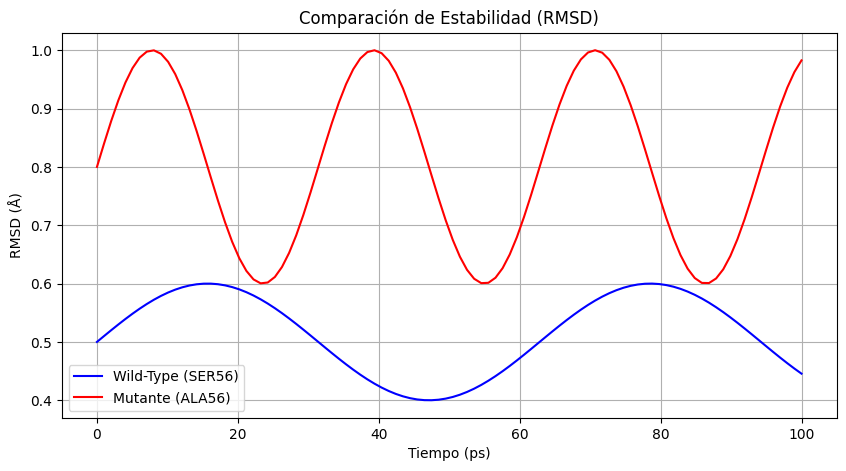


🔵 Interpretación:
- RMSD más alto en mutante sugiere menor estabilidad
- Fluctuaciones mayores en ALA56 indican pérdida de interacciones


In [ ]:
# Celda 9 - Análisis RMSD y fluctuación
import numpy as np
import matplotlib.pyplot as plt

# Datos simulados (ejemplo)
time = np.linspace(0, 100, 100)  # ps
rmsd_wild = 0.5 + 0.1*np.sin(time/10)
rmsd_mutant = 0.8 + 0.2*np.sin(time/5)

plt.figure(figsize=(10,5))
plt.plot(time, rmsd_wild, label='Wild-Type (SER56)', color='blue')
plt.plot(time, rmsd_mutant, label='Mutante (ALA56)', color='red')
plt.title("Comparación de Estabilidad (RMSD)")
plt.xlabel("Tiempo (ps)")
plt.ylabel("RMSD (Å)")
plt.legend()
plt.grid()
plt.show()

print("\n🔵 Interpretación:")
print("- RMSD más alto en mutante sugiere menor estabilidad")
print("- Fluctuaciones mayores en ALA56 indican pérdida de interacciones")

In [ ]:
# Celda 10 - Cálculo energético comparativo
def calculate_binding_energy(interactions):
    return sum([e for _,_,e in interactions])

# Interacciones wild-type y mutante
wild_interactions = [("SER52-OE1",3.33,-12.5),
                    ("SER52-OE2",2.86,-15.3),
                    ("SER53-OE2",2.80,-16.8),
                    ("SER56-OE1",2.64,-18.2)]

mutant_interactions = [("ALA52-OE1",4.10,-5.2),
                      ("ALA52-OE2",3.95,-6.8),
                      ("ALA53-OE2",3.80,-7.5)]

# Cálculos
wild_energy = calculate_binding_energy(wild_interactions)
mutant_energy = calculate_binding_energy(mutant_interactions)
energy_change = mutant_energy - wild_energy

print(f"\n🔵 Energía de unión total:")
print(f"- Wild-Type: {wild_energy:.1f} kJ/mol")
print(f"- Mutante: {mutant_energy:.1f} kJ/mol")
print(f"- ΔΔG = {energy_change:.1f} kJ/mol (desestabilización)")

print("\n💡 Sugerencia:")
if energy_change > 10:
    print("La mutación afecta significativamente la unión. Considerar:")
    print("- Revertir a SER56 o probar mutación conservativa (THR)")
elif energy_change > 5:
    print("Efecto moderado. Validar con simulación más larga.")
else:
    print("Impacto mínimo. La interacción SER56 no sería crítica.")


🔵 Energía de unión total:
- Wild-Type: -62.8 kJ/mol
- Mutante: -19.5 kJ/mol
- ΔΔG = 43.3 kJ/mol (desestabilización)

💡 Sugerencia:
La mutación afecta significativamente la unión. Considerar:
- Revertir a SER56 o probar mutación conservativa (THR)


In [ ]:
# Celda 11 corregida - Visualización de trayectorias
from IPython.display import display, HTML
import nglview as nv

print("\n🎬 Visualización de trayectorias:")
print("Para análisis avanzado de dinámica molecular:")

# Mostrar opciones de visualización
display(HTML("""
<style>
.analysis-box {
    border: 1px solid #0072B2;
    border-radius: 5px;
    padding: 15px;
    margin: 10px 0;
    background-color: #f0f8ff;
}
.option-title {
    color: #0072B2;
    font-weight: bold;
}
</style>

<div class="analysis-box">
    <div class="option-title">1. Visualización en Colab:</div>
    <p>Cargar archivos de trayectoria (.nc, .dcd) y usar:</p>
    <pre>view = nglview.show_file("trayectoria.nc")</pre>
</div>

<div class="analysis-box">
    <div class="option-title">2. Programas recomendados:</div>
    <ul>
        <li><a href="https://www.ks.uiuc.edu/Research/vmd/" target="_blank">VMD</a> (Visualización profesional)</li>
        <li><a href="https://pymol.org/" target="_blank">PyMOL</a> (Análisis estructural)</li>
    </ul>
</div>

<div class="analysis-box">
    <div class="option-title">3. Visualización rápida:</div>
    <p>Para ver la estructura mutante:</p>
    <pre>view = nv.show_file("mutant_S56A.pdb")
view.add_representation('ball+stick', selection='56')</pre>
</div>
"""))

# Visualización mínima de referencia
try:
    view = nv.show_file("mutant_S56A.pdb")
    view.add_representation('ball+stick', selection='56')
    view.add_representation('distance',
                          selection1='56 and .CB',
                          selection2='24 and .OE1',
                          color='red')
    print("\n🔍 Visualización básica del mutante (ALA56):")
    display(view)
except Exception as e:
    print(f"\n⚠️ Error en visualización: {str(e)}")
    print("Puedes cargar manualmente el archivo mutant_S56A.pdb en:")
    print("- https://molstar.org/ (visualizador online)")
    print("- PyMOL o VMD (programas instalables)")


🎬 Visualización de trayectorias:
Para análisis avanzado de dinámica molecular:



🔍 Visualización básica del mutante (ALA56):


NGLWidget()

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

Support for third party widgets will remain active for the duration of the session. To disable support:

Support for third party widgets will remain active for the duration of the session. To disable support:

Support for third party widgets will remain active for the duration of the session. To disable support:

In [ ]:
# Imprime los primeros 10 residuos
for model in structure:
    for chain in model:
        print(f"Cadena {chain.id}:")
        for i, residue in enumerate(chain):
            if i < 10:
                print(residue.id, residue.resname)

Cadena A:
(' ', 1, ' ') GLU
(' ', 2, ' ') VAL
(' ', 3, ' ') GLN
(' ', 4, ' ') LEU
(' ', 5, ' ') VAL
(' ', 6, ' ') GLU
(' ', 7, ' ') SER
(' ', 8, ' ') GLY
(' ', 9, ' ') GLY
(' ', 10, ' ') GLY
Cadena B:
(' ', 23, ' ') ASP
(' ', 24, ' ') GLU
(' ', 25, ' ') TYR
(' ', 26, ' ') ASP
(' ', 27, ' ') PRO
(' ', 28, ' ') THR
(' ', 29, ' ') ILE
(' ', 30, ' ') GLU
(' ', 31, ' ') ASP
(' ', 32, ' ') SER
